In [418]:
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt
# Sample Data

patients = pd.read_csv("~/Database/patient_metadata.csv")
data_metadata = pd.read_csv("~/Database/data_metadata.csv")
redcap = pd.read_csv("~/Database/Redcap_metadata.csv", low_memory=False)
sample_metadata = pd.read_csv("~/Database/sample_metadata.csv")
patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
patient_info = patient_info.dropna(axis=1, how="all")

diagnosis_treatment = redcap[
    (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
    (redcap["Repeat Instrument"] == "Treatment at Study Site")
]

diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")

print(patient_info.columns,data_metadata.columns, sample_metadata.columns, patients.columns, data_metadata.columns)

Index(['REDCap Record ID', 'Subject ID', 'Updated By', 'Date of Last Update',
       'Gender', 'Race', 'Religion', 'Date of Last Follow Up',
       'Date of Consent for Sarcoma/Melanoma/GIST Study', 'Waiver of Consent',
       'Date of Confirmed Sarcoma/Melanoma/GIST Diagnosis', 'Survival Status',
       'If Survival Status is Died of Other Cause, please specify',
       'Date of Death', 'Date of Last Seen Alive',
       'If Alive with Disease, please specify site(s) of disease (choice=Local)',
       'If Alive with Disease, please specify site(s) of disease (choice=Lung)',
       'If Alive with Disease, please specify site(s) of disease (choice=Bone)',
       'If Alive with Disease, please specify site(s) of disease (choice=Brain)',
       'If Alive with Disease, please specify site(s) of disease (choice=Liver)',
       'If Alive with Disease, please specify site(s) of disease (choice=Lymph Node)',
       'If Alive with Disease, please specify site(s) of disease (choice=Distant Soft T

In [419]:

def merge_dataframes_by_common_columns(dataframes, how="inner"):
    """Merges multiple DataFrames based on their common column names."""

    if not isinstance(dataframes, (list, tuple)):
        raise TypeError("Input must be a list or tuple of DataFrames.")  # Raise exception

    if len(dataframes) < 2:
        raise ValueError("At least two DataFrames are required.")  # Raise exception

    # Find common columns using a more robust approach
    common_columns = list(dataframes[0].columns) # Start with the first dataframe columns as a list
    for df in dataframes[1:]:
        common_columns = list(set(common_columns) & set(df.columns)) # Find intersection and convert to list

    if not common_columns:
        raise ValueError("No common columns found among the DataFrames.")  # Raise exception

    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=common_columns, how=how)

    return merged_df

In [425]:
dataframe=([patient_info, patients, data_metadata, sample_metadata])
def clean_column_names(df):
    df.columns = (df.columns
                  .str.strip()  # Remove leading/trailing spaces
                  .str.lower()  # Convert to lowercase
                  .str.replace(' ', '_', regex=False))  # Replace spaces with underscores
    return df

for df in dataframe:
    df = clean_column_names(df)

for i, df in enumerate(dataframe):
    print(f"DataFrame {i+1} Columns:")
    print(df.columns.tolist())  # Print as a list for easy inspection
    # OR, for even more detail:
    for col in df.columns:
        print(f"'{col}'")  # Print each column name with quotes
    print("-" * 20)  # Separator


dict = find_common_columns_between_pairs(dataframe)
print(dict)

DataFrame 1 Columns:
['redcap_record_id', 'subject_id', 'updated_by', 'date_of_last_update', 'gender', 'race', 'religion', 'date_of_last_follow_up', 'date_of_consent_for_sarcoma/melanoma/gist_study', 'waiver_of_consent', 'date_of_confirmed_sarcoma/melanoma/gist_diagnosis', 'survival_status', 'if_survival_status_is_died_of_other_cause,_please_specify', 'date_of_death', 'date_of_last_seen_alive', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=local)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=lung)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=bone)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=brain)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=liver)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=lymph_node)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(choice=distant_soft_tissue)', 'if_alive_with_disease,_please_specify_site(s)_of_disease_(c

In [421]:
def find_common_columns_between_pairs(dataframes):
    """
    Finds common column names between each pair of DataFrames in a list.

    Args:
        dataframes: A list of Pandas DataFrames.

    Returns:
        A dictionary where keys are tuples of DataFrame indices (i, j)
        representing the pairs, and values are lists of common column names.
        Returns an empty dictionary if no common columns are found between any pair
        or if the input is invalid.
    """

    if not isinstance(dataframes, list):
        raise TypeError("Input must be a list of DataFrames.")

    if len(dataframes) < 2:
        raise ValueError("At least two DataFrames are required.")

    num_dfs = len(dataframes)
    common_columns_dict = {}

    for i in range(num_dfs):
        for j in range(i + 1, num_dfs):  # Avoid comparing a DataFrame to itself and avoid duplicates (i,j) and (j,i)
            df1 = dataframes[i]
            df2 = dataframes[j]

            common_cols = list(set(df1.columns) & set(df2.columns))  # Efficient intersection

            if common_cols:
                common_columns_dict[(i, j)] = common_cols

    return common_columns_dict

In [447]:

def merge_dataframes(dfs, merge_info):
    """
    Merges multiple dataframes based on a dictionary of common columns.
    
    Parameters:
        dfs (dict): A dictionary where keys are dataframe indices and values are pandas DataFrames.
        merge_info (dict): A dictionary where keys are tuples of dataframe indices (df1, df2),
                           and values are lists of common columns to merge on.
    
    Returns:
        pd.DataFrame: The final merged dataframe.
    """
    # Start with the first dataframe from dfs
    dfs = {i: dataframe[i] for i in range(len(dataframe))}
    merged_df = dfs[list(dfs.keys())[0]].copy()  

    for (df1, df2), common_cols in merge_info.items():
        print(f"Merging df{df1} with df{df2} on {common_cols}")
        print(f"df{df1} columns: {dfs[df1].columns.tolist()}")
        print(f"df{df2} columns: {dfs[df2].columns.tolist()}\n")
        
        # Ensure common columns exist before merging
        existing_cols = [col for col in common_cols if col in dfs[df1].columns and col in dfs[df2].columns]
        
        if not existing_cols:
            print(f"Skipping merge between df{df1} and df{df2}, no common columns found!")
            continue
        
        merged_df = merged_df.merge(dfs[df2], on=existing_cols, how='outer')
    
    return merged_df


In [449]:
# Example usage:

dataframe=[patient_info,patients, data_metadata,sample_metadata]
dataframe_dict = find_common_columns_between_pairs(dataframe)
merged_df = merge_dataframes(dataframe,dataframe_dict)


AttributeError: 'list' object has no attribute 'keys'

In [422]:
def get_radial_distance(data_type):
     radial_distances = {
        "in-vitro_dosing": 100,
        " in-vitro dosing": 100,
        "WES": 150,
        "LongReadSeq": 200,
        "RNAseq": 250,
        "scRNAseq": 300,
        "WTA Probe Sequencing": 350,
    }
     return radial_distances.get(data_type, 400)  # Very Light Blue as default


In [185]:
import altair as alt


def interactive_plot(combined_df):    
    # Process the data for pie chart with percentage
    disease_counts = combined_df['Pathologic Diagnosis'].value_counts().reset_index()
    disease_counts.columns = ['Pathologic Diagnosis', 'Count']

    # Calculate percentage
    total_count = disease_counts['Count'].sum()
    disease_counts['Percentage'] = (disease_counts['Count'] / total_count) * 100
    disease_counts['Percentage'] = disease_counts['Percentage'].map('{:.1f}%'.format)
    # Selection filter
    disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")

    # Create an Altair Pie Chart with Percentage Display
    disease_pie = (
        alt.Chart(disease_counts)
        .mark_arc(innerRadius=50)
        .encode(
            theta=alt.Theta("Count:Q", title="Total Cases"),
            color=alt.Color(
                "Pathologic Diagnosis:N",
                scale=alt.Scale(scheme="category20"),
                legend=alt.Legend(title="Pathologic Diagnosis", orient="left")  # Custom legend title for Pathology
            ),
            opacity=alt.condition(disease_select, alt.value(1), alt.value(0.3)),
            tooltip=[
                "Pathologic Diagnosis:N",
                "Percentage",
                alt.Tooltip("Percentage:Q", format=".1f")]
        )
        .add_selection(disease_select)
        .properties(title="Pathologic Diagnosis Distribution", width=400, height=400)
    )
    project_patient_counts = (
        combined_df.groupby(["Pathologic Diagnosis", "Project ID", "Data_type"])["Patient ID"]
        .nunique()  # Count unique patients
        .reset_index()
    )
    # Rename columns for clarity
    project_patient_counts.columns = ["Pathologic Diagnosis", "Project ID", "Data_type", "Number of Patients"]

    # Summary Bar Chart (Filtered by Pie Selection)
    datatype_summary = (
        alt.Chart(project_patient_counts)
        .mark_bar()
        .encode(
            x=alt.X("Project ID:N", title="Project ID"),
            y=alt.Y("Number of Patients:Q", title="Number of Patients"),
            tooltip=["Project ID", "Number of Patients","Data_type"],
            color=alt.Color("Data_type:N",
                scale=alt.Scale(scheme="category20"),
                legend=alt.Legend(title="Data_type", orient="left") 
        ))
        .transform_filter(disease_select)  # Apply the filter from the pie chart
        .properties(title="Patients per Project (Filtered by Disease)", width=500)
    )

    treatment = (
        combined_df.groupby(["Pathologic Diagnosis", "Cancer treatment regimen 1"])["Patient ID"]
        .nunique()  # Count unique patients
        .reset_index()
    )
    # Rename columns for clarity
    treatment.columns = ["Pathologic Diagnosis", "", "Number of Patients"]

    # Summary Bar Chart (Filtered by Pie Selection)
    Diagnosis_summary = (
        alt.Chart(treatment)
        .mark_bar()
        .encode(
            x=alt.X("Treatment:N", title="Treatment"),
            y=alt.Y("Number of Patients:Q", title="Number of Patients"),
            tooltip=["Treatment", "Number of Patients"],
            color=alt.Color("Treatment:N",
                scale=alt.Scale(scheme="category20"),
                legend=alt.Legend(title="Treatment:N", orient="left"))
        )
        .transform_filter(disease_select)  # Apply the filter from the pie chart
        .properties(title="Patients per Project (Filtered by Disease)", width=500)
    )


    # Combine both charts
    chart_row = (disease_pie | datatype_summary).resolve_scale(
        color='independent'  # Crucial: Make the color scales independent
    )
    chart_row = (chart_row & Diagnosis_summary).resolve_scale(color="independent")
    return(chart_row)

In [212]:

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame 
from pyvis.network import Network
import math


# Define a function to generate unique shades of green for each Data_Type
def get_data_type_color(data_type):
    # Define a list of blue shades (from light to dark, well-differentiated)
    blue_shades = {
        "in_vitro_dosing": "#ADD8E6", 
        " in-vitro dosing": "#ADD8E6",# Light Blue (Powder Blue)
        "WES": "#87CEEB",  # Sky Blue
        "LongReadSeq": "#4682B4",  # Steel Blue
        "RNAseq": "#2969AF",  # Royal Blue (slightly darker)
        "scRNAseq": "#1E90FF",  # Dodger Blue
        "WTA Probe Sequencing": "#0077B5"  # Medium Blue (LinkedIn Blue - distinct)
    }
    return blue_shades.get(data_type, "#E0F2F7")  # Very Light Blue as default

def get_radial_distance(data_type):
     radial_distances = {
        "in_vitro_dosing": 100,
        " in-vitro dosing": 100,
        "WES": 150,
        "LongReadSeq": 200,
        "RNAseq": 250,
        "scRNAseq": 300,
        "WTA Probe Sequencing": 350,
    }
     return radial_distances.get(data_type, 400)  # Very Light Blue as default

def create_network_graph(df):
    # Initialize a Pyvis network
    net = Network(height="750px", width="100%", directed=True, notebook=True,  cdn_resources='in_line')
    
    # Define colors for other node types
    patient_color = "lightgrey"
    project_color = "orange"
    
    # Add nodes and edges to the network
    for _, row in df.iterrows():
        patient_id = str(row["Patient ID"])
        project_id = str(row["Project ID"])
        data_type = str(row["Data_type"])
        
        net.add_node(project_id, label=project_id, title=f"{project_id}", color=project_color, size =30)
        radius = 200  # Distance from the center
        angle_step = 2 * math.pi / len(patient_id)  # Equal spacing
        # Add Patient and Project nodes
        for i, patient in enumerate(patient_id):
            x = radius * math.cos(i * angle_step)
            y = radius * math.sin(i * angle_step)
            net.add_node(patient, label=patient, physics=False, x=x, y=y)
            net.add_edge(project_id, patient)


        # Get the color for this Data_Type using the mapping function
        data_type_color = get_data_type_color(data_type)
        data_type_distance = get_radial_distance(data_type)
        # Add Data_Type node for the patient with a unique color
        data_type_node = f"{patient_id}_{data_type}"  # Create a unique ID for each Data_Type per Patient
        net.add_node(data_type_node, label=data_type, title=f"{data_type}", color=data_type_color)
        # - Between Patient and Data_Type
        net.add_edge(patient, data_type_node, overlap=0, spring_length =20)
   # Disable physics to stop nodes from shaking
          # Disable physics to stop nodes from shaking
    return net

In [241]:
project_patient_counts = (
    combined_df.groupby(["Pathologic Diagnosis", "Project ID", "Data_type","Sample ID"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)

In [250]:
combined_df = pd.merge(data_metadata, , on="Patient ID")
project_patient_counts = (
    data_metadata.groupby([ "Project ID", "Data_type","Sample ID"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
filtered_df = project_patient_counts[project_patient_counts["Patient ID"] > 1]
filtered_df

,Project ID,Data_type,Sample ID,Patient ID
103,SARC_GeoMX,WTA Probe Sequencing,1,10
168,SARC_PDSC_Resource,WES,1,8
199,SARC_PDSC_Resource,WGS,1,3


In [190]:
interactive_plot(combined_df)

/tmp/ipykernel_17817/2446255591.py:14: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")
/tmp/ipykernel_17817/2446255591.py:33: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  .add_selection(disease_select)


alt.VConcatChart(...)

In [191]:
# Process the data for pie chart with percentage
disease_counts = combined_df['Pathologic Diagnosis'].value_counts().reset_index()
disease_counts.columns = ['Pathologic Diagnosis', 'Count']

# Calculate percentage
total_count = disease_counts['Count'].sum()
disease_counts['Percentage'] = (disease_counts['Count'] / total_count) * 100
disease_counts['Percentage'] = disease_counts['Percentage'].map('{:.1f}%'.format)
# Selection filter
disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")

# Create an Altair Pie Chart with Percentage Display
disease_pie = (
    alt.Chart(disease_counts)
    .mark_arc(innerRadius=50)
    .encode(
        theta=alt.Theta("Count:Q", title="Total Cases"),
        color=alt.Color(
            "Pathologic Diagnosis:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Pathologic Diagnosis", orient="left")  # Custom legend title for Pathology
        ),
        opacity=alt.condition(disease_select, alt.value(1), alt.value(0.3)),
        tooltip=[
            "Pathologic Diagnosis:N",
            "Percentage",
            alt.Tooltip("Percentage:Q", format=".1f")]
    )
    .add_selection(disease_select)
    .properties(title="Pathologic Diagnosis Distribution", width=400, height=400)
)
project_patient_counts = (
    combined_df.groupby(["Pathologic Diagnosis", "Project ID", "Data_type"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
# Rename columns for clarity
project_patient_counts.columns = ["Pathologic Diagnosis", "Project ID", "Data_type", "Number of Patients"]

# Summary Bar Chart (Filtered by Pie Selection)
datatype_summary = (
    alt.Chart(project_patient_counts)
    .mark_bar()
    .encode(
        x=alt.X("Project ID:N", title="Project ID"),
        y=alt.Y("Number of Patients:Q", title="Number of Patients"),
        tooltip=["Project ID", "Number of Patients","Data_type"],
        color=alt.Color("Data_type:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Data_type", orient="left") 
    ))
    .transform_filter(disease_select)  # Apply the filter from the pie chart
    .properties(title="Patients per Project (Filtered by Disease)", width=500)
)

treatment = (
    combined_df.groupby(["Pathologic Diagnosis", "Cancer treatment regimen 1"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
# Rename columns for clarity
treatment.columns = ["Pathologic Diagnosis", "Treatment", "Number of Patients"]

# Summary Bar Chart (Filtered by Pie Selection)
Diagnosis_summary = (
    alt.Chart(treatment)
    .mark_bar()
    .encode(
        x=alt.X("Treatment:N", title="Treatment"),
        y=alt.Y("Number of Patients:Q", title="Number of Patients"),
        tooltip=["Treatment", "Number of Patients"],
        color=alt.Color("Treatment:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Treatment:N", orient="left"))
    )
    .transform_filter(disease_select)  # Apply the filter from the pie chart
    .properties(title="Patients per Project (Filtered by Disease)", width=500)
)


# Combine both charts
chart_row = (disease_pie | datatype_summary & Diagnosis_summary).resolve_scale(
    color='independent'  # Crucial: Make the color scales independent
)
chart_row

/tmp/ipykernel_17817/1676239158.py:10: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")
/tmp/ipykernel_17817/1676239158.py:29: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  .add_selection(disease_select)


alt.HConcatChart(...)

In [331]:
# Sample Data
patients = pd.read_csv("~/Database/patient_metadata.csv")
data_metadata = pd.read_csv("~/Database/data_metadata.csv")
redcap = pd.read_csv("~/Database/Redcap_metadata.csv", low_memory=False)
analysis_mapper = pd.read_csv("~/Database/data_analysis_mapper.csv")
patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
patient_info = patient_info.dropna(axis=1, how="all")

diagnosis_treatment = redcap[
    (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
    (redcap["Repeat Instrument"] == "Treatment at Study Site")
]
diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")

merged = pd.merge(patient_info, diagnosis_treatment, on="REDCap Record ID", how="outer")
final_df = pd.concat([patient_info, merged], ignore_index=True)

merged_df = pd.merge(patients[["REDCAP ID","Patient ID"]], final_df, left_on="REDCAP ID", right_on="REDCap Record ID", how="outer")

analysis_merge = pd.merge(
    data_metadata, 
    analysis_mapper, 
    on=["Patient ID", "Specimen ID", "Sample ID"], 
    how="outer"
)



merged_df = pd.merge(merged_df, analysis_merge, on="Patient ID")

print(merged_df.columns)



Index(['REDCAP ID', 'Patient ID', 'REDCap Record ID', 'Subject ID',
       'Updated By', 'Date of Last Update', 'Gender', 'Race', 'Religion',
       'Date of Last Follow Up',
       ...
       'Original Location', 'Catalog Location', 'File type', 'Reference',
       'Analysis', 'Analysis remarks', 'Remarks_y', 'Out Analysis ID',
       'File ID_y', 'In Analysis ID'],
      dtype='object', length=311)


              Data_type  Count
0       in-vitro dosing    202
1       Oncomine Report     18
2                RNAseq   2337
3                   WES    977
4                   WGS    136
5  WTA Probe Sequencing     12
6       in_vitro_dosing    303
7              scRNAseq    248


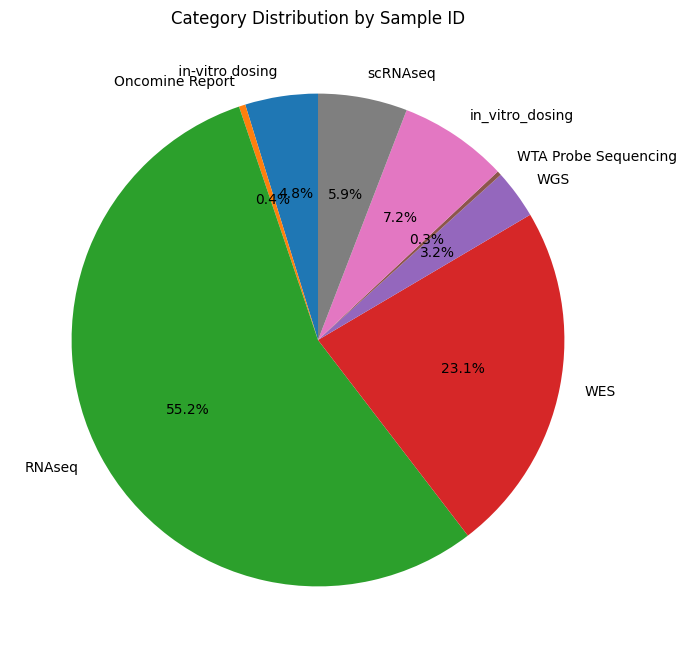

In [361]:
import altair as alt
import pandas as pd

# Assuming merged_df is your DataFrame
# Group by 'Data_type', 'File type', 'Patient ID', and 'Specimen ID' and count unique 'Sample ID's
piechart = merged_df.groupby(["Data_type", "File type", "Patient ID", "Specimen ID"])["Sample ID"].size().reset_index(name="Count")

# Group by 'Data_type' to get counts for pie chart
counts = piechart.groupby("Data_type")["Count"].sum().reset_index()

# Create a selection object for interactivity
selection = alt.selection_single(fields=['Data_type'], bind='legend', name="Select Data Type")

# Create the pie chart using Altair
pie = alt.Chart(counts).mark_arc().encode(
    theta='Count:Q',
    color='Data_type:N',
    tooltip=['Data_type:N', 'Count:Q'],
).add_selection(
    selection
).properties(
    title="Category Distribution by Data Type"
)

# Show the pie chart in Streamlit
altair_chart(pie, use_container_width=True)

# Filter the data based on the selected Data_type
filtered_data = piechart[piechart["Data_type"].isin(counts[selection.selected]["Data_type"])]

# Get the file types for the selected Data_type
file_type_counts = filtered_data.groupby("File type")["Count"].sum().reset_index()

# Create a bar chart for File types using Altair
bar = alt.Chart(file_type_counts).mark_bar().encode(
    x='File type:N',
    y='Count:Q',
    color='File type:N',
    tooltip=['File type:N', 'Count:Q']
).properties(
    title="File Types for Selected Data Type"
)

# Show the bar chart in Streamlit
altair_chart(bar, use_container_width=True)
